In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import itertools
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [2]:
def calc_params(w,l):
    num_params = 784*w
    for i in range(l-2):
        num_params += w*w
    num_params += w*10
    return num_params

def get_width(percent):
    num_params = calc_params(128,2)/percent
    a = 2 #l?
    width = (-794+np.sqrt(794**2+4*a*num_params))/(2*a)
    return int(width)

print("Percent of Overparametrized Network")
print("W = 128:",calc_params(128,2)/calc_params(128,4))
print("W = 256:",calc_params(128,2)/calc_params(256,4))
print("W = 512:",calc_params(128,2)/calc_params(512,4))
print("W = 1024:",calc_params(128,2)/calc_params(1024,4))

print("\nWidth of Overparametrized Network (Twice as Deep)")
print("10%:",get_width(0.1))
print("20%:",get_width(0.2))
print("30%:",get_width(0.3))
print("40%:",get_width(0.4))
print("50%:",get_width(0.5))

Percent of Overparametrized Network
W = 128: 0.7561904761904762
W = 256: 0.30398162327718226
W = 512: 0.10918591859185918
W = 1024: 0.03492258972554539

Width of Overparametrized Network (Twice as Deep)
10%: 541
20%: 343
30%: 258
40%: 209
50%: 177


In [3]:
calc_params(128,2)

101632

MLP Model

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MLP, self).__init__()

        # Check if number of layers is at least 1
        if num_layers < 1:
            raise ValueError("Number of layers must be at least 1")

        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size, bias=False))

        # Additional hidden layers
        for _ in range(1, num_layers):
            layers.append(nn.Linear(hidden_size, hidden_size, bias=False))

        # Output layer
        layers.append(nn.Linear(hidden_size, output_size, bias=False))

        # ModuleList of layers
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the input

        # Apply all layers except the last
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))

        # Apply the last layer without ReLU
        x = self.layers[-1](x)

        return x

Helper Functions

In [5]:
def evaluate(model, test_loader):
    model.eval()
    model.to(device)  # Move the model to the configured device
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss += batch_loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_loss = loss / total
    return test_accuracy, test_loss

def evaluate_masked_model_loss_and_accuracy(model, concatenated_mask, initial_weights, test_loader, criterion, num_batches=10):

    # Split the concatenated mask back into individual masks
    split_indices = np.cumsum([len(w.flatten()) for w in initial_weights[:-1]])
    masks = np.split(concatenated_mask, split_indices)

    # Reshape each mask to match the corresponding weight matrix
    for j, w in enumerate(initial_weights):
        masks[j] = masks[j].reshape(w.shape)

    # Apply the mask to the initial weights
    masked_weights = [w * m for w, m in zip(initial_weights, masks)]

    # Set the masked weights to the model
    with torch.no_grad():
        for param, weight in zip(model.parameters(), masked_weights):
            param.data = torch.tensor(weight).float()

    # Evaluate the model's performance using a subset of the test data
    accuracy, loss = evaluate(model, itertools.islice(test_loader, num_batches))

    return accuracy, loss

def sort_and_evaluate_masks(mask_pop, model, initial_weights, test_loader, criterion, num_batches, print_results=False):
    performance = []

    for i, mask in enumerate(mask_pop):
        accuracy, avg_test_loss = evaluate_masked_model_loss_and_accuracy(model, mask, initial_weights, test_loader, criterion, num_batches)
        performance.append((mask, accuracy, avg_test_loss))

    # Sort by accuracy (descending)
    #-x[2] -> sort by loss, x[1] -> accuracy
    sorted_performance = sorted(performance, key=lambda x: x[1], reverse=True)

    # Print sorted results
    if print_results:
        for i, (mask, accuracy, avg_test_loss) in enumerate(sorted_performance):
            print(f"Ranked {i+1}, Mask {i}: Test Accuracy = {accuracy:.2f}%, Test Loss = {avg_test_loss:.4f}")

    # Return sorted mask population
    sorted_mask_pop = [mask for mask, _, _ in sorted_performance]
    sorted_accuracies = [accuracy for _, accuracy, _ in sorted_performance]
    #sorted_losses = [loss for _, _, loss in sorted_performance]
    return sorted_mask_pop, sorted_accuracies#, sorted_losses

def evaluate_mask_sizes(mask_pop):
    total_weights = sum(w.size for w in mask_pop[0])
    mask_sizes = []

    for masks in mask_pop:
        non_zero_weights = sum(np.count_nonzero(m) for m in masks)
        mask_size_percentage = (non_zero_weights / total_weights) * 100
        mask_sizes.append(mask_size_percentage)

    return mask_sizes

Evolution

In [6]:
def initialize_masks(weights,target_params,num_subnets=10):

    # Flatten and concatenate all weight matrices
    concatenated_weights = np.concatenate([w.flatten() for w in weights])

    # Determine number of weights to zero out
    num_zero_out = int(len(concatenated_weights)-target_params)
    mask_pop = []

    for i in range(num_subnets):

        # Randomly choose indices to zero out
        zero_indices = np.random.choice(len(concatenated_weights), num_zero_out, replace=False)

        # Create a mask for concatenated weights
        concatenated_mask = np.ones_like(concatenated_weights)
        concatenated_mask[zero_indices] = 0

        #add to population
        mask_pop.append(concatenated_mask)

    return mask_pop

def mutate_mask(mask, m):

    mutated_mask = mask.copy()

    # Get the indices of ones and zeros
    one_indices = np.where(mutated_mask == 1)[0]
    zero_indices = np.where(mutated_mask == 0)[0]

    # Randomly select m ones and zeros to switch
    selected_ones = np.random.choice(one_indices, m, replace=False)
    selected_zeros = np.random.choice(zero_indices, m, replace=False)

    # Switch selected ones and zeros
    mutated_mask[selected_ones] = 0
    mutated_mask[selected_zeros] = 1

    return mutated_mask

def crossover_mask(mask1, mask2):

    crossover_point = random.randint(1, len(mask1) - 1)

    # Combine initial segments up to the crossover point
    new_mask = np.concatenate([mask1[:crossover_point], mask2[crossover_point:]])

    # Count zeros and ones in the new mask and the parents
    num_zeros = np.sum(mask1 == 0)  # assuming mask1 and mask2 have the same number of zeros
    current_zeros = np.sum(new_mask == 0)

    # Balance zeros and ones if required
    if current_zeros != num_zeros:
        if current_zeros > num_zeros:
            # Too many zeros, replace some with ones
            zero_indices = np.where(new_mask[crossover_point:] == 0)[0] + crossover_point
            ones_to_flip = zero_indices[:current_zeros - num_zeros]
            new_mask[ones_to_flip] = 1
        else:
            # Too few zeros, replace some ones with zeros
            one_indices = np.where(new_mask[crossover_point:] == 1)[0] + crossover_point
            zeros_to_flip = one_indices[:(num_zeros - current_zeros)]
            new_mask[zeros_to_flip] = 0

    return new_mask

def evolutionary_optimization(model, initial_weights, test_loader, criterion, num_batches, num_epochs=100, num_subnets=10, target_params=0, n=5, m=5, crossover_rate=0.5, print_accuraies = True):
    mask_pop = initialize_masks(initial_weights, target_params, num_subnets=num_subnets)
    top_accuracies = []

    for epoch in range(num_epochs):
        mask_pop, accuracies = sort_and_evaluate_masks(mask_pop, model, initial_weights, test_loader, criterion, num_batches)
        top_mask_accuracy = accuracies[0]
        top_accuracies.append(top_mask_accuracy)
        if print_accuraies:
            print(f"Epoch {epoch + 1}/{num_epochs}: Highest Accuracy = {top_mask_accuracy:.2f}")

        #terminate + elitism
        mask_pop = mask_pop[:n]

        new_masks = []

        for i in range(num_subnets-n):
            parent1 = mask_pop[random.randint(0, n-1)]
            parent2 = mask_pop[random.randint(0, n-1)]
            if random.random() < crossover_rate:  # crossover_rate is a hyperparameter
                new_mask = crossover_mask(parent1, parent2)
            else:
                new_mask = mutate_mask(parent1, m)  # or mutate_mask(parent2, m)
            new_masks.append(new_mask)

        mask_pop = mask_pop + new_masks

        assert len(mask_pop) == num_subnets

    #mask_sizes = evaluate_mask_sizes(mask_pop)
    #print(mask_sizes)

    return top_accuracies

Data Loader

In [7]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Learning Curve

In [9]:
import time

num_batches = 1
num_epochs = 1000
num_subnets = 10

def perform_evaluation(width):
    # Initialize parameters
    target_params = calc_params(128, 2)
    criterion = nn.CrossEntropyLoss()
    num_batches = 1
    num_epochs = 1000
    num_subnets = 10
    n = 2  # number to keep
    m = 1000  # number of mutations to mask
    crossover_rate = 0
    num_iter = 10

    # Initialize a list to store the accuracies from all iterations for this width
    all_accuracies = []

    # Print model parameters
    print("Width =", width, "--", calc_params(width, 4), "params --", target_params / calc_params(width, 4), "% mask")

    for i in range(num_iter):

        # Initialize Model
        model = MLP(28 * 28, width, 10, 3).to(device)

        # Save a copy of the initial weights to list of numpy arrays
        initial_weights = [layer.weight.detach().cpu().clone().numpy() for layer in model.layers]

        # Start timing
        start_time = time.time()

        # Perform the evolutionary optimization
        evolutionary_accuracies = evolutionary_optimization(model, initial_weights, test_loader, criterion, num_batches, num_epochs, num_subnets, target_params, n, m, crossover_rate, print_accuraies=False)

        # End timing
        end_time = time.time()
        print(f"Width {width}, Iteration {i+1}: {end_time - start_time:.2f} seconds")

        # Store the accuracies
        all_accuracies.append(evolutionary_accuracies)
    return all_accuracies
    

In [1]:
import concurrent.futures

# List of widths to iterate over
widths = [128, 256]

# Initialize a dictionary to store the accuracies for each width
all_accuracies_dict = {}

# Use ThreadPoolExecutor to parallelize the loop
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Map the function over the list of widths, running each in a separate thread
    results = list(executor.map(perform_evaluation, widths))

# Store the results in the dictionary
for width, accuracies in zip(widths, results):
    all_accuracies_dict[width] = np.array(accuracies)

widths2 = [512, 1028]

# Use ThreadPoolExecutor to parallelize the loop
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Map the function over the list of widths, running each in a separate thread
    results = list(executor.map(perform_evaluation, widths2))

# Store the results in the dictionary
for width, accuracies in zip(widths2, results):
    all_accuracies_dict[width] = np.array(accuracies)

# Plotting
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs + 1)

for width, all_accuracies in all_accuracies_dict.items():
    # Calculate the average and standard deviation across iterations for each epoch
    avg_accuracies = np.mean(all_accuracies, axis=0)
    std_dev_accuracies = np.std(all_accuracies, axis=0)

    # Plot for each width
    plt.plot(epochs, avg_accuracies, label=f'Width {width} Average Accuracy')
    plt.fill_between(epochs, avg_accuracies - std_dev_accuracies, avg_accuracies + std_dev_accuracies, alpha=0.2)

plt.xlabel('Epochs')
plt.ylabel('Average Evolutionary Accuracy')
plt.title('Average Evolutionary Accuracies vs Epochs with Standard Deviation for Different Widths')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'perform_evaluation' is not defined

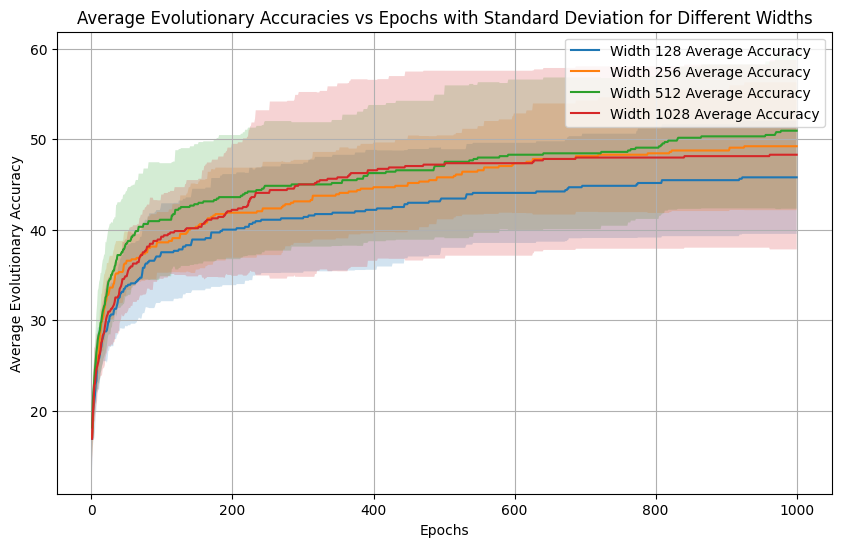

Final Accuracies
Width 128: 45.78 +- 6.25
Width 256: 49.22 +- 7.07
Width 512: 50.94 +- 8.62
Width 1028: 48.28 +- 10.47


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
epochs = range(1, num_epochs + 1)

for width, all_accuracies in all_accuracies_dict.items():
    # Calculate the average and standard deviation across iterations for each epoch
    avg_accuracies = np.mean(all_accuracies, axis=0)
    std_dev_accuracies = np.std(all_accuracies, axis=0)

    # Plot for each width
    plt.plot(epochs, avg_accuracies, label=f'Width {width} Average Accuracy')
    plt.fill_between(epochs, avg_accuracies - std_dev_accuracies, avg_accuracies + std_dev_accuracies, alpha=0.2)

plt.xlabel('Epochs')
plt.ylabel('Average Evolutionary Accuracy')
plt.title('Average Evolutionary Accuracies vs Epochs with Standard Deviation for Different Widths')
plt.legend()
plt.grid(True)
plt.show()

print("Final Accuracies")
for width, all_accuracies in all_accuracies_dict.items():
    # Calculate the average and standard deviation across iterations for each epoch
    avg_accuracies = np.mean(all_accuracies, axis=0)
    std_dev_accuracies = np.std(all_accuracies, axis=0)
    print(f"Width {width}: {avg_accuracies[-1]:.2f} +- {std_dev_accuracies[-1]:.2f}")